# Construction du classifieur


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import pandas as pd
import cv2
import os
from skimage import io, util
from skimage.transform import resize


from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    average_precision_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Récupération des jeux


In [2]:
f_labels = [
    f
    for f in os.listdir(os.path.join("data", "train", "labels_csv"))
    if f.endswith(".csv")
]
print(f_labels)


img_pos_train = []


img_neg_train = []


bbox_train = []

i = 0
for f in f_labels:
    i += 1

    bbox = np.loadtxt(os.path.join("data", "train", "labels_csv", f), delimiter=",")
    # vérifier que bbox est une liste de liste ou bien la liste des infos
    if bbox.ndim == 1:
        bbox = [bbox]

    bbox_train.append(bbox)

    try:

        img_pos = plt.imread(
            os.path.join("data", "train", "images", "pos", f.replace(".csv", ".jpg"))
        )
        img_pos_train.append(img_pos)

    except FileNotFoundError:

        continue

    try:

        img_neg = plt.imread(
            os.path.join("data", "train", "images", "neg", f.replace(".csv", ".jpg"))
        )
        img_neg_train.append(img_neg)

    except FileNotFoundError:

        continue

['0000.csv', '0001.csv', '0002.csv', '0003.csv', '0004.csv', '0005.csv', '0006.csv', '0007.csv', '0008.csv', '0009.csv', '0010.csv', '0011.csv', '0012.csv', '0013.csv', '0014.csv', '0015.csv', '0016.csv', '0017.csv', '0018.csv', '0019.csv', '0020.csv', '0021.csv', '0022.csv', '0023.csv', '0024.csv', '0025.csv', '0026.csv', '0027.csv', '0028.csv', '0029.csv', '0030.csv', '0031.csv', '0032.csv', '0033.csv', '0034.csv', '0035.csv', '0036.csv', '0037.csv', '0038.csv', '0039.csv', '0040.csv', '0041.csv', '0042.csv', '0043.csv', '0044.csv', '0045.csv', '0046.csv', '0047.csv', '0048.csv', '0049.csv', '0050.csv', '0051.csv', '0052.csv', '0053.csv', '0054.csv', '0055.csv', '0056.csv', '0057.csv', '0058.csv', '0059.csv', '0060.csv', '0061.csv', '0062.csv', '0063.csv', '0064.csv', '0065.csv', '0066.csv', '0067.csv', '0068.csv', '0069.csv', '0070.csv', '0071.csv', '0072.csv', '0073.csv', '0074.csv', '0075.csv', '0076.csv', '0077.csv', '0078.csv', '0079.csv', '0080.csv', '0081.csv', '0082.csv', '00

In [3]:
print(len(bbox_train))

313


## Découper les écocups et les négatifs


On découpe les positifs en fonction de bbox


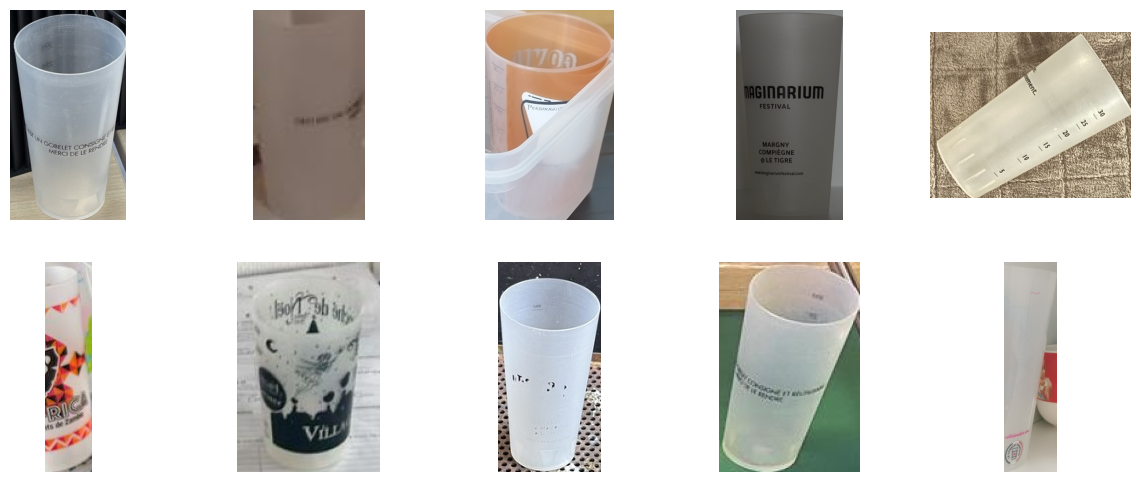

In [4]:
img_pos_train_cut = []
for i in range(len(bbox_train)):
    bbox_list = bbox_train[i]
    img = img_pos_train[i]

    for bbox in bbox_list:
        upper_left_corner_Y = int(bbox[0])
        upper_left_corner_X = int(bbox[1])
        height = int(bbox[2])
        width = int(bbox[3])

        lower_right_corner_Y = upper_left_corner_Y + height
        lower_right_corner_X = upper_left_corner_X + width

        img_cut = img[
            upper_left_corner_Y:lower_right_corner_Y,
            upper_left_corner_X:lower_right_corner_X,
        ]
        img_pos_train_cut.append(img_cut)

# Afficher 10 images aléatoires de la liste img_pos_train_cut
random.shuffle(img_pos_train_cut)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    if i < len(img_pos_train_cut):
        ax.imshow(img_pos_train_cut[i])
        ax.axis("off")
    else:
        ax.axis("off")

On va découper des bouts d'images négatives


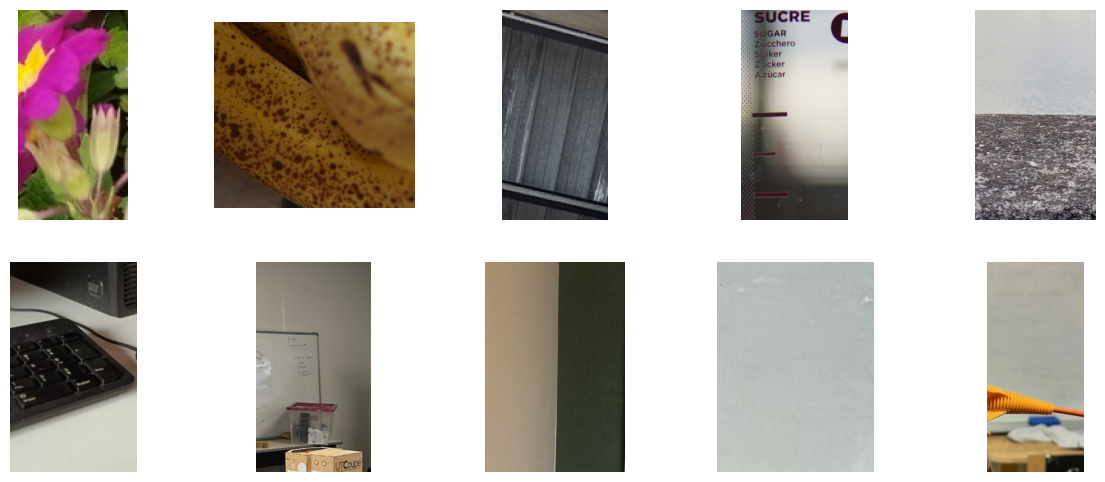

In [5]:
img_neg_train_cut = []
for i in range(len(img_neg_train)):
    img = img_neg_train[i]

    # On prend de manière aléatoirement 3 bbox (nombre purement arbitraire)
    for _ in range(3):
        # nombre aleatoire parmis bbox
        random_bbox = random.choice(random.choice(bbox_train))
        upper_left_corner_Y = int(random_bbox[0])
        upper_left_corner_X = int(random_bbox[1])
        height = int(random_bbox[2])
        width = int(random_bbox[3])
        lower_right_corner_Y = upper_left_corner_Y + height
        lower_right_corner_X = upper_left_corner_X + width

        img_cut = img[
            upper_left_corner_Y:lower_right_corner_Y,
            upper_left_corner_X:lower_right_corner_X,
        ]
        img_neg_train_cut.append(img_cut)

# Afficher 10 images aléatoires de la liste img_neg_train_cut
random.shuffle(img_neg_train_cut)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    if i < len(img_neg_train_cut):
        ax.imshow(img_neg_train_cut[i])
        ax.axis("off")
    else:
        ax.axis("off")

In [6]:
print("img_pos_train:", len(img_pos_train))
print("len(bbox_train):", len(bbox_train))

img_pos_train: 313
len(bbox_train): 313


## Transformation


Supprimer les images vides


In [7]:
# Généré par Copilot
for i, img in enumerate(img_neg_train_cut):
    if img is None:
        print(f"Image {i} is None")
        # supprimer l'image de la liste
        img_neg_train_cut.pop(i)
    elif isinstance(img, np.ndarray) and img.size == 0:
        print(f"Image {i} is empty (zero size)")
        img_neg_train_cut.pop(i)

Image 154 is empty (zero size)
Image 157 is empty (zero size)
Image 176 is empty (zero size)
Image 309 is empty (zero size)
Image 348 is empty (zero size)
Image 358 is empty (zero size)


Transformer les imaged pour qu'elles soient à la même taille


In [8]:
target_shape = (64, 64)  # à tuner pour les performances

img_pos_train_cut_resized = [
    resize(img, target_shape, anti_aliasing=True) for img in img_pos_train_cut
]
img_neg_train_cut_resized = [
    resize(img, target_shape, anti_aliasing=True) for img in img_neg_train_cut
]

La commande ci-dessous permet de convertir
les valeurs des pixels à valeurs entières [[0; 255]] en valeurs flottantes [0; 1]


In [9]:
img_pos_train_cut_resized_float = [
    util.img_as_float(img) for img in img_pos_train_cut_resized
]
img_neg_train_cut_resized_float = [
    util.img_as_float(img) for img in img_neg_train_cut_resized
]

On souhaite utiliser directement les pixels comme représentation des images. La commande
I.flatten() permet d’aplatir l’image pour obtenir un vecteur


In [10]:
img_pos_train_cut_resized_float_flatten = [
    img.flatten() for img in img_pos_train_cut_resized_float
]
img_neg_train_cut_resized_float_flatten = [
    img.flatten() for img in img_neg_train_cut_resized_float
]

## Construire les jeux


In [11]:
y = []
X = img_pos_train_cut_resized_float_flatten + img_neg_train_cut_resized_float_flatten
for bbox_list in bbox_train:
    for bbox in bbox_list:
        y.append(int(bbox[4] + 1))
for _ in range(len(img_neg_train_cut_resized_float_flatten)):
    y.append(0)

#### Créer une pondération pour les exemples difficiles


In [12]:
# Création de la pondération pour les cas difficiles
w = np.ones_like(y)
w[y == 2] = 0.5  # A tuner pour la performance

y_clean = np.array(y)
for i in range(len(y_clean)):
    if y_clean[i] == 2:
        y_clean[i] = 1  # On remplace les 2 par des 1 pour la classification binaire

In [13]:
print(len(X), len(y))

928 928


#### Diviser le jeu


In [18]:
train_part = 80 / 100
train_size = int(len(X) * train_part)

# Problème: tout est dans l'ordre, nous devons donc associer chaque image à sa vérité et mélanger les données
indices = np.arange(len(X))
np.random.shuffle(indices)
X_shuffled = np.array(X)[indices]
y_shuffled = np.array(y_clean)[indices]
w_shuffled = np.array(w)[indices]


X_train = X_shuffled[0:train_size]
y_train = y_shuffled[0:train_size]
w_train = w_shuffled[0:train_size]
X_validation = X_shuffled[train_size:]
y_validation = y_shuffled[train_size:]
w_validation = w_shuffled[train_size:]


print(len(X_train))
print(len(y_train))
print(len(w_train))
print(len(X_validation))
print(len(y_validation))
print(len(w_validation))

742
742
742
186
186
186


## Choix du classifieur


Nous allons choisir le classifieur le plus efficace parmis un certain nombre de classifieurs


In [25]:
def test_model(
    name, model, X_train, y_train, weight, X_validation, y_validation, df_resultat_clf
):

    print(f"Testing {name}...")

    # model.fit(X_train, y_train, sample_weight=weight)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_validation)

    accuracy = accuracy_score(y_validation, y_pred, sample_weight=w_validation)

    error = (1 - accuracy) * 100
    # Calculer le rappel et la précision
    rappel = recall_score(y_validation, y_pred, sample_weight=w_validation)
    precision = precision_score(y_validation, y_pred, sample_weight=w_validation)
    f1_score = 2 * (precision * rappel) / (precision + rappel)
    avg_precision_score = average_precision_score(
        y_validation, y_pred, sample_weight=w_validation
    )

    df_resultat_clf = pd.concat(
        [
            df_resultat_clf,
            pd.DataFrame(
                [
                    {
                        "model": name,
                        "accuracy": accuracy,
                        "error%": error,
                        "rappel": rappel,
                        "precision": precision,
                        "f1_score": f1_score,
                        "average_precision_score": avg_precision_score,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
    return df_resultat_clf

In [22]:
def get_models_dict():

    models_dict = {}
    # KNN
    neighbors_list = [3, 25, 100, 250]
    for neighbors in neighbors_list:
        knn = KNeighborsClassifier(n_neighbors=neighbors)
        models_dict[f"KNN (k={neighbors})"] = knn

    # Decision Tree
    decision_tree = DecisionTreeClassifier()
    models_dict["Decision Tree"] = decision_tree

    # Random Forest
    estimators_list = [3, 25, 100, 250]
    for estimators in estimators_list:
        random_forest = RandomForestClassifier(n_estimators=estimators)
        models_dict[f"Random Forest (n_estimators={estimators})"] = random_forest

    # SVC
    svc = SVC()
    models_dict["SVC"] = svc

    # LinearSVC
    linear_svc = LinearSVC()
    models_dict["Linear SVC"] = linear_svc

    # SVC kernel
    svc_kernel_list = ["poly", "rbf", "sigmoid"]
    for kernel in svc_kernel_list:
        svc_kernel = SVC(kernel=kernel)
        models_dict[f"SVC (kernel={kernel})"] = svc_kernel

    # Logistic Regression
    iter_list = [25, 200, 400]
    for n_iter in iter_list:
        logistic_regression = LogisticRegression(max_iter=n_iter)
        models_dict[f"Logistic Regression (max_iter={n_iter})"] = logistic_regression

    # AdaBoost
    estimators_list = [10, 25, 100]
    for estimators in estimators_list:
        ada_boost = AdaBoostClassifier(n_estimators=estimators)
        models_dict[f"AdaBoost (n_estimators={estimators})"] = ada_boost

    return models_dict

    # Gradient Boosting
    learning_rate_list = [0.01, 0.2, 0.5]
    for learning_rate in learning_rate_list:
        gradient_boosting = GradientBoostingClassifier(learning_rate=learning_rate)
        models_dict[f"Gradient Boosting (learning_rate={learning_rate})"] = (
            gradient_boosting
        )
    return models_dict

In [26]:
df_resultat_clf = pd.DataFrame(
    columns=[
        "model",
        "accuracy",
        "error%",
        "rappel",
        "precision",
        "f1_score",
        "average_precision_score",
    ]
)

models_dict = get_models_dict()


for name, model in models_dict.items():
    df_resultat_clf = test_model(
        name, model, X_train, y_train, w, X_validation, y_validation, df_resultat_clf
    )

df_resultat_clf = df_resultat_clf.sort_values(by="error%")
print(df_resultat_clf)

Testing KNN (k=3)...


C:\Users\engel\AppData\Local\Temp\ipykernel_20908\287718513.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultat_clf = pd.concat(


Testing KNN (k=25)...
Testing KNN (k=100)...
Testing KNN (k=250)...
Testing Decision Tree...
Testing Random Forest (n_estimators=3)...
Testing Random Forest (n_estimators=25)...
Testing Random Forest (n_estimators=100)...
Testing Random Forest (n_estimators=250)...
Testing SVC...
Testing Linear SVC...


c:\Users\engel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\engel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Testing SVC (kernel=poly)...
Testing SVC (kernel=rbf)...
Testing SVC (kernel=sigmoid)...
Testing Logistic Regression (max_iter=25)...


c:\Users\engel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing Logistic Regression (max_iter=200)...


c:\Users\engel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing Logistic Regression (max_iter=400)...
Testing AdaBoost (n_estimators=10)...


c:\Users\engel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Testing AdaBoost (n_estimators=25)...


c:\Users\engel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Testing AdaBoost (n_estimators=100)...


c:\Users\engel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


                                 model  accuracy     error%  rappel  \
7     Random Forest (n_estimators=100)  0.817204  18.279570    0.84   
8     Random Forest (n_estimators=250)  0.806452  19.354839    0.84   
11                   SVC (kernel=poly)  0.790323  20.967742    0.72   
9                                  SVC  0.784946  21.505376    0.86   
12                    SVC (kernel=rbf)  0.784946  21.505376    0.86   
6      Random Forest (n_estimators=25)  0.779570  22.043011    0.81   
18          AdaBoost (n_estimators=25)  0.747312  25.268817    0.84   
2                          KNN (k=100)  0.741935  25.806452    0.77   
17          AdaBoost (n_estimators=10)  0.731183  26.881720    0.78   
14   Logistic Regression (max_iter=25)  0.731183  26.881720    0.79   
19         AdaBoost (n_estimators=100)  0.731183  26.881720    0.81   
3                          KNN (k=250)  0.720430  27.956989    0.90   
15  Logistic Regression (max_iter=200)  0.698925  30.107527    0.69   
13    

In [27]:
df_resultat_clf.head()

,model,accuracy,error%,rappel,precision,f1_score,average_precision_score
7,Random Forest (n_estimators=100),0.817204,18.279570,0.84,0.823529,0.831683,0.777786
8,Random Forest (n_estimators=250),0.806452,19.354839,0.84,0.807692,0.823529,0.764483
11,SVC (kernel=poly),0.790323,20.967742,0.72,0.867470,0.786885,0.775116
9,SVC,0.784946,21.505376,0.86,0.767857,0.811321,0.735626
12,SVC (kernel=rbf),0.784946,21.505376,0.86,0.767857,0.811321,0.735626


In [28]:
## Affichons les 3 meilleurs résultats pour chaque score
# accuracy
top_accuracy = df_resultat_clf.nlargest(3, "accuracy")
print("Top 3 Accuracy:")
print(top_accuracy[["model", "accuracy"]])

# rappel
top_recall = df_resultat_clf.nlargest(3, "rappel")
print("\nTop 3 Rappel:")
print(top_recall[["model", "rappel"]])

# précision
top_precision = df_resultat_clf.nlargest(3, "precision")
print("\nTop 3 Précision:")
print(top_precision[["model", "precision"]])

# f1_score
top_f1_score = df_resultat_clf.nlargest(3, "f1_score")
print("\nTop 3 F1 Score:")
print(top_f1_score[["model", "f1_score"]])

# average_precision_score
top_avg_precision = df_resultat_clf.nlargest(3, "average_precision_score")
print("\nTop 3 Average Precision Score:")
print(top_avg_precision[["model", "average_precision_score"]])

Top 3 Accuracy:
                               model  accuracy
7   Random Forest (n_estimators=100)  0.817204
8   Random Forest (n_estimators=250)  0.806452
11                 SVC (kernel=poly)  0.790323

Top 3 Rappel:
               model  rappel
3        KNN (k=250)    0.90
9                SVC    0.86
12  SVC (kernel=rbf)    0.86

Top 3 Précision:
                               model  precision
11                 SVC (kernel=poly)   0.867470
7   Random Forest (n_estimators=100)   0.823529
8   Random Forest (n_estimators=250)   0.807692

Top 3 F1 Score:
                              model  f1_score
7  Random Forest (n_estimators=100)  0.831683
8  Random Forest (n_estimators=250)  0.823529
9                               SVC  0.811321

Top 3 Average Precision Score:
                               model  average_precision_score
7   Random Forest (n_estimators=100)                 0.777786
11                 SVC (kernel=poly)                 0.775116
8   Random Forest (n_estimators=250)

In [29]:
# enregistrer le dataframe
df_resultat_clf.to_csv("resultats_classification.csv", index=False)

## Analyse

Au vu des résultats précédents, nous pensons que les meilleurs algorithmes pour la suite sont Random Forest et  SVC (kernel=poly)

Nous allons donc par la suite essayer de les tuner pour obtenir les performances maximales